# Случайный лес

В этом практическом задании вы решите задачу регрессии на реальных данных при помощи линейной модели и случайного леса. 

## Цели практической работы

* Научиться применять случайный лес в задаче регрессии.
* Научиться сравнивать качество случайного леса с качеством линейной модели.
* Научиться настраивать гиперпараметры леса.

## Что входит в работу

* Выполнить предобработку данных.
* Обучить линейную регрессию на данных задачи.
* Обучить случайный лес на данных задачи.
* Подобрать гиперпараметры для леса.
* Визуализировать важность признаков у леса.

## Что оценивается

*  Все ячейки заполнены; при запуске ячеек  Python не выдаёт информацию об ошибках.
*  Качество итоговой модели $R^2$ превышает 0,95.


## Что нужно сделать

Постройте модели, предсказывающие стоимость автомобилей по характеристикам.

Признаков у машин много, но в этой работе обойдёмся только числовыми признаками:
*  year — год производства автомобиля;
*  km_driven — пробег;
*  seats — количество посадочных мест;
*  mileage — другая характеристика пробега;
*  engine — мощность двигателя;
*  max_power — мощность автомобиля.

Целевая переменная — selling_price.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
import seaborn as sns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_csv("data/cars_train.csv")
test = pd.read_csv("data/cars_test.csv")
print(train.shape)
print(test.shape)

(6998, 13)
(1000, 13)


Посмотрим дубликаты и пропуски

In [3]:
# дубликаты
df = train
print('duplicated', sum(df.duplicated()), 'shape', df.shape)
# пропуски
missing_values_tr = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
print('missing_tr', missing_values_tr)

# дубликаты
df = test
print('duplicated_test', sum(df.duplicated()), 'shape', df.shape)
# пропуски
missing_values_test = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
print('missing_test_%', missing_values_test)

duplicated 985 shape (6998, 13)
missing_tr mileage          7.159188
engine           7.159188
torque           7.159188
seats            7.159188
max_power        7.073450
year             4.272649
selling_price    4.272649
km_driven        4.272649
fuel             4.272649
seller_type      4.272649
transmission     4.272649
owner            4.272649
name             0.000000
dtype: float64
duplicated_test 62 shape (1000, 13)
missing_test_% mileage          1.9
engine           1.9
max_power        1.9
torque           1.9
seats            1.9
name             0.0
year             0.0
selling_price    0.0
km_driven        0.0
fuel             0.0
seller_type      0.0
transmission     0.0
owner            0.0
dtype: float64


В тренировочных данных есть автомобили, для которых неизвестна стоимость. Удалите эти автомобили из трейна.

In [4]:
print(train.shape)
train = train.dropna(subset=['selling_price'])
train.shape

(6998, 13)


(6699, 13)

Создайте объекты Xtrain, ytrain, Xtest, ytest. Запишите в них матрицы «объект — признак» и векторы целевой переменной для тренировочного и тестового датасетов.

In [5]:
X = train.drop('selling_price', axis=1)
y = train.selling_price

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [6]:
print(x_train.shape)
x_train.head()

(4689, 12)


,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
4442,Maruti Eeco CNG HTR 5-STR,2014.0,90000.0,CNG,Individual,Manual,First Owner,21.94 km/kg,1196 CC,63 bhp,83Nm@ 3000rpm,5.0
5413,Maruti Wagon R LXI,2006.0,168000.0,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0
867,Toyota Innova 2.5 Z Diesel 7 Seater BS IV,2015.0,114368.0,Diesel,Dealer,Manual,Second Owner,12.99 kmpl,2494 CC,100.6 bhp,200Nm@ 1200-3600rpm,7.0
1125,Maruti Swift ZDi,2014.0,100000.0,Diesel,Individual,Manual,Second Owner,22.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
5484,Maruti Ritz VDi,2012.0,80000.0,Diesel,Individual,Manual,Third Owner,23.2 kmpl,1248 CC,73.94 bhp,190Nm@ 2000rpm,5.0


Перед обучением моделей обработайте данные.

Обратите внимание, что столбцы mileage, engine и max_power по смыслу числовые. Чтобы превратить их в числовые столбцы, отбросьте единицы измерения и оставьте только числа. В столбцах есть пропущенные значения, их при обработке трогать не нужно.

In [7]:
# Преобразование столбцов mileage
x_train['mileage'] = x_train['mileage'].str.replace(' km/kg', '', regex=False)
x_train['mileage'] = x_train['mileage'].str.replace(' kmpl', '', regex=False)
x_train['mileage'] = x_train['mileage'].str.replace(' ', '', regex=False)  # Удаление пробелов
x_train['mileage'] = x_train['mileage'].astype(float)

In [8]:
# Преобразование столбцов engine
x_train['engine'] = x_train['engine'].str.replace(' ', '', regex=False)
x_train['engine'] = x_train['engine'].str.replace('CC', '')
# Теперь преобразуем в числовой тип с оставлением NaN
x_train['engine'] = pd.to_numeric(x_train['engine'], errors='coerce')

In [9]:
# Преобразование столбцов max_power
x_train['max_power'] = x_train['max_power'].str.replace(' bhp', '').astype(float)

In [10]:
x_test['mileage'] = x_test['mileage'].str.replace(' km/kg', '', regex=False)
x_test['mileage'] = x_test['mileage'].str.replace(' kmpl', '', regex=False)
x_test['mileage'] = x_test['mileage'].str.replace(' ', '', regex=False)  # Удаление пробелов
x_test['mileage'] = x_test['mileage'].astype(float)
x_test['engine'] = x_test['engine'].str.replace(' ', '', regex=False)
x_test['engine'] = x_test['engine'].str.replace('CC', '')
x_test['engine'] = pd.to_numeric(x_test['engine'], errors='coerce')
x_test['max_power'] = x_test['max_power'].str.replace(' bhp', '').astype(float)


In [11]:
print(x_train.shape)
x_train.head()

(4689, 12)


,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
4442,Maruti Eeco CNG HTR 5-STR,2014.0,90000.0,CNG,Individual,Manual,First Owner,21.94,1196.0,63.00,83Nm@ 3000rpm,5.0
5413,Maruti Wagon R LXI,2006.0,168000.0,Petrol,Individual,Manual,Second Owner,18.90,998.0,67.10,90Nm@ 3500rpm,5.0
867,Toyota Innova 2.5 Z Diesel 7 Seater BS IV,2015.0,114368.0,Diesel,Dealer,Manual,Second Owner,12.99,2494.0,100.60,200Nm@ 1200-3600rpm,7.0
1125,Maruti Swift ZDi,2014.0,100000.0,Diesel,Individual,Manual,Second Owner,22.90,1248.0,74.00,190Nm@ 2000rpm,5.0
5484,Maruti Ritz VDi,2012.0,80000.0,Diesel,Individual,Manual,Third Owner,23.20,1248.0,73.94,190Nm@ 2000rpm,5.0


Оставьте в данных только шесть числовых столбцов:

year, km_driven, seats, engine, mileage, max_power

In [12]:
x_train = x_train[['year', 'km_driven', 'seats', 'mileage', 'engine', 'max_power']]
#x_test = x_test[['year', 'km_driven', 'seats', 'mileage', 'engine', 'max_power']]
x_train.head()

,year,km_driven,seats,mileage,engine,max_power
4442,2014.0,90000.0,5.0,21.94,1196.0,63.00
5413,2006.0,168000.0,5.0,18.90,998.0,67.10
867,2015.0,114368.0,7.0,12.99,2494.0,100.60
1125,2014.0,100000.0,5.0,22.90,1248.0,74.00
5484,2012.0,80000.0,5.0,23.20,1248.0,73.94


Теперь заполните пропуски следующим образом:

*    вычислите средние значения по столбцам тренировочной выборки;

*    добавьте в пропуски в тренировочных и тестовых данных вычисленные средние.

In [13]:
# пропуски
print('x_train', ((x_train.isna().sum() / len(x_train)) * 100).sort_values(ascending=False))
x_train.fillna(x_train.mean().iloc[0], inplace=True)
print('x_train', ((x_train.isna().sum() / len(x_train)) * 100).sort_values(ascending=False))
x_train.head()


x_train seats        2.964385
mileage      2.964385
engine       2.964385
max_power    2.921732
year         0.000000
km_driven    0.000000
dtype: float64
x_train year         0.0
km_driven    0.0
seats        0.0
mileage      0.0
engine       0.0
max_power    0.0
dtype: float64


,year,km_driven,seats,mileage,engine,max_power
4442,2014.0,90000.0,5.0,21.94,1196.0,63.00
5413,2006.0,168000.0,5.0,18.90,998.0,67.10
867,2015.0,114368.0,7.0,12.99,2494.0,100.60
1125,2014.0,100000.0,5.0,22.90,1248.0,74.00
5484,2012.0,80000.0,5.0,23.20,1248.0,73.94


In [14]:
print('x_test', ((x_test.isna().sum() / len(x_test)) * 100).sort_values(ascending=False))
x_test.fillna(x_train.mean().iloc[0], inplace=True)
print('x_test', ((x_test.isna().sum() / len(x_test)) * 100).sort_values(ascending=False))

x_test mileage         3.134328
engine          3.134328
torque          3.134328
seats           3.134328
max_power       2.935323
name            0.000000
year            0.000000
km_driven       0.000000
fuel            0.000000
seller_type     0.000000
transmission    0.000000
owner           0.000000
dtype: float64
x_test name            0.0
year            0.0
km_driven       0.0
fuel            0.0
seller_type     0.0
transmission    0.0
owner           0.0
mileage         0.0
engine          0.0
max_power       0.0
torque          0.0
seats           0.0
dtype: float64


Теперь на обработанных тренировочных данных обучите:

*  линейную регрессию,
*  случайный лес с параметрами по умолчанию.

На обработанных тестовых данных сделайте предсказание и вычислите метрику $R^2$. 

In [15]:
# Линейная регрессиия

linreg = LinearRegression()
linreg.fit(x_train, y_train)

# убираем лишние признаки на тесте
col = x_train.columns
x_test = x_test[col]

linreg_pred = linreg.predict(x_test)

# Расчет R²
r2_linreg = r2_score(y_test, linreg_pred)

#print("Предсказанные значения:", linreg_pred)
print("Коэффициент детерминации R²:", r2_linreg)

Коэффициент детерминации R²: 0.26361620709143563


In [16]:
# Дерево

dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)

# убираем лишние признаки на тесте
col = x_train.columns
x_test = x_test[col]

dtr_pred = dtr.predict(x_test)

# Расчет R²
r2_dtr = r2_score(y_test, dtr_pred)

print("Коэффициент детерминации R²:", r2_dtr)

Коэффициент детерминации R²: 0.8934516135420392


In [17]:
# Случайный лес

rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)

# убираем лишние признаки на тесте
col = x_train.columns
x_test = x_test[col]

rfr_pred = rfr.predict(x_test)

# Расчет R²
r2_rfr = r2_score(y_test, rfr_pred)

print("Коэффициент детерминации R²:", r2_rfr)

Коэффициент детерминации R²: 0.93750983610531


Какая модель получилась лучше?

In [18]:
# Ваш ответ здесь
# Случайный лес, однако показания метрики кажутся несколько завышенными

Улучшите качество предсказания случайного леса путём подбора гиперпараметров:

*   n_estimators,
*   max_depth,
*   max_features,
*   min_samples_leaf,
*   min_samples_split.

Для подбора гиперпараметров используйте GridSearchCV. Обучайте GridSearchCV по тренировочным данным с разбивкой на три фолда и метрикой $R^2$.

In [19]:
# Ваш код здесь
N = []
r2 = []

for n in np.arange(10, 120, 20):
    rf = RandomForestRegressor(n_estimators = n)

    rf.fit(x_train, y_train)

    pred_rf = rf.predict(x_test)

    N.append(n)
    r2.append(r2_score(y_test, pred_rf))

Text(0, 0.5, 'MSE on test')

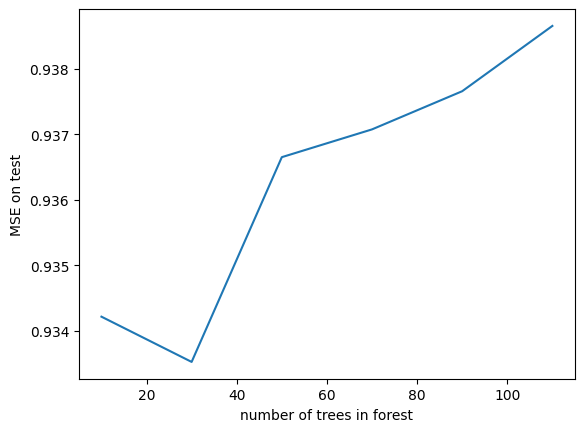

In [20]:
plt.plot(N, r2, '-')
plt.xlabel('number of trees in forest')
plt.ylabel('MSE on test')

In [21]:
# Grid n_estimators

params = {'n_estimators' : np.arange(2, 50, 5)}

gs = GridSearchCV(RandomForestRegressor(), params, cv=3, scoring='r2')

gs.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47])},
             scoring='r2')

In [22]:
estimator = gs.best_estimator_
estimator

RandomForestRegressor(n_estimators=32)

In [33]:
# Grid max_depth
params = {'max_depth' : np.arange(2, 25, 4)}
gs = GridSearchCV(RandomForestRegressor(n_estimators=32), params, cv=3, scoring='r2')
gs.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_estimators=32),
             param_grid={'max_depth': array([ 2,  6, 10, 14, 18, 22])},
             scoring='r2')

In [34]:
gs.best_params_

{'max_depth': 22}

In [36]:
# Grid max_features
params = {'max_features' : ['sqrt', 'log2', None]}
gs = GridSearchCV(RandomForestRegressor(n_estimators=32, max_depth=22), params, cv=3, scoring='r2')
gs.fit(x_train, y_train)
gs.best_params_

{'max_features': 'sqrt'}

In [37]:
# Grid min_samples_leaf
params = {'min_samples_leaf' : [1, 2, 4, 6, 8]}
gs = GridSearchCV(RandomForestRegressor(n_estimators=32, max_depth=2, max_features='sqrt'), params, cv=3, scoring='r2')
gs.fit(x_train, y_train)
gs.best_params_

{'min_samples_leaf': 2}

In [38]:
# Grid min_samples_split
params = {'min_samples_split' : [2, 5, 10, 15]}
gs = GridSearchCV(RandomForestRegressor(n_estimators=32, max_depth=22, max_features='sqrt', min_samples_leaf=2), params, cv=3, scoring='r2')
gs.fit(x_train, y_train)
gs.best_params_

{'min_samples_split': 5}

Теперь обучите на тренировочных данных случайный лес с найденными гиперпараметрами. Сделайте предсказание на тестовых данных и оцените его качество ($R^2$).

In [39]:
rfr_grid = RandomForestRegressor(n_estimators=32, max_depth=22, max_features='sqrt', min_samples_leaf=2, min_samples_split=5)

rfr_grid.fit(x_train, y_train)

# убираем лишние признаки на тесте
col = x_train.columns
x_test = x_test[col]

rfr_grid_pred = rfr_grid.predict(x_test)

# Расчет R²
r2_rfr_grid = r2_score(y_test, rfr_grid_pred)

print("R² параметры по умолчанию:", r2_rfr)
print("R² GridS:", r2_rfr_grid)

R² параметры по умолчанию: 0.93750983610531
R² GridS: 0.92623136725679


Модель готова. Осталось её проинтерпретировать.

При помощи метода model.feature_importances_ визуализируйте гистограмму важности признаков у случайного леса с настроенными гиперпараметрами.

In [44]:
feature_names = x_train.columns

# Модель линейной регрессии
linreg_importance = np.abs(linreg.coef_[0])
# Модель RandomForest параметры по умолчанию
rfr_importance = rfr.feature_importances_
# Модель RandomForest GridS
rfr_grid_importance = rfr_grid.feature_importances_

In [45]:
# Создание DataFrame для удобства работы
importance_df = pd.DataFrame({
    'Feature': feature_names,  
    'LinearRegression': linreg_importance,
    'RFR_defolt': rfr_importance,
    'RFR_Grid': rfr_grid_importance
})

In [46]:
# Списки для трех самых важных признаков
top_linreg = importance_df.nlargest(3, 'LinearRegression')
top_rfr = importance_df.nlargest(3, 'RFR_defolt')
top_rfr_grid = importance_df.nlargest(3, 'RFR_Grid')

# Выводим три самых важных признака
print("features LinearRegression:", top_linreg)
print("\nfeatures RFR_defolt:", top_rfr)
print("\nfeatures RFR_Grid:", top_rfr_grid)

features LinearRegression:      Feature  LinearRegression  RFR_defolt  RFR_Grid
0       year      56922.847947    0.341653  0.224235
1  km_driven      56922.847947    0.032766  0.098684
2      seats      56922.847947    0.012531  0.064396

features RFR_defolt:      Feature  LinearRegression  RFR_defolt  RFR_Grid
5  max_power      56922.847947    0.554089  0.365937
0       year      56922.847947    0.341653  0.224235
1  km_driven      56922.847947    0.032766  0.098684

features RFR_Grid:      Feature  LinearRegression  RFR_defolt  RFR_Grid
5  max_power      56922.847947    0.554089  0.365937
0       year      56922.847947    0.341653  0.224235
4     engine      56922.847947    0.026438  0.174965


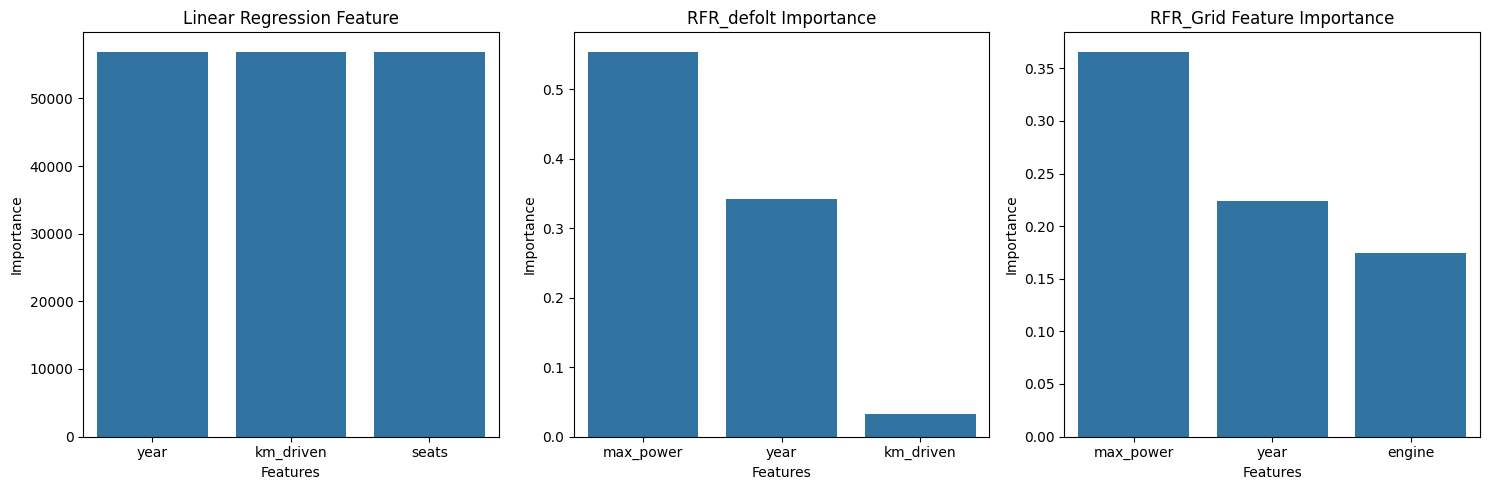

In [47]:


# Построение гистограмм важности признаков
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=top_linreg['Feature'], y=top_linreg['LinearRegression'])
plt.title('Linear Regression Feature')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.subplot(1, 3, 2)
sns.barplot(x=top_rfr['Feature'], y=top_rfr['RFR_defolt'])
plt.title('RFR_defolt Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.subplot(1, 3, 3)
sns.barplot(x=top_rfr_grid['Feature'], y=top_rfr_grid['RFR_Grid'])
plt.title('RFR_Grid Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()